In [1]:
import torch, torchvision
import torch.nn.functional as F
from torch.optim import SGD,Adam,AdamW
from torch.utils.data import DataLoader
from torchcontrib.optim import SWA
from torch import optim

# import oil.model_trainers as trainers
from oil.datasetup.datasets import CIFAR10, split_dataset
from oil.utils.utils import Eval, LoaderTo, cosLr, dmap, FixedNumpySeed, FixedPytorchSeed

from flow_ssl.data.nlp_datasets import AG_News,YAHOO

from utils.utils import swaLR, calibration_curve, get_ensembles_accuracy
from models import RealNVPTabularWPrior, SemiFlow
from ensembles import Ensembles

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import collections

import warnings
# warnings.filterwarnings("ignore")

In [2]:
def makeTrainer(train_data, test_data, bs=5000, split={'train':200,'val':5000},
                network=RealNVPTabularWPrior, net_config={}, num_epochs=15,
                optim=AdamW, lr=1e-3, opt_config={'weight_decay':1e-5},
                swa=False, swa_config={'swa_dec_pct':.5, 'swa_start_pct':.75, 'swa_freq_pct':.05, 'swa_lr_factor':.1},
                trainer=SemiFlow, trainer_config={'log_dir':os.path.expanduser('~/tb-experiments/UCI/'),'log_args':{'minPeriod':.1, 'timeFrac':3/10}},
                dev='cuda', save=False):
    with FixedNumpySeed(0):
        datasets = split_dataset(train_data,splits=split)
        datasets['_unlab'] = dmap(lambda mb: mb[0],train_data)
        datasets['test'] = test_data
        
    device = torch.device(dev)
    
    dataloaders = {k : LoaderTo(DataLoader(v,
                                         batch_size=min(bs,len(datasets[k])),
                                         shuffle=(k=='train'),
                                         num_workers=0,
                                         pin_memory=False),
                              device) 
                   for k, v in datasets.items()}
    dataloaders['Train'] = dataloaders['train']
    
    model = network(num_classes=train_data.num_classes, dim_in=train_data.dim, **net_config).to(device)
    
    opt_constr = partial(optim, lr=lr, **opt_config)
    
    if swa == True:
        lr_sched = partial(swaLR, num_epochs=num_epochs, **swa_config)
    else:
        lr_sched = cosLr(num_epochs)
    #     lr_sched = lambda e:1
    return trainer(model,dataloaders, swa, opt_constr,lr_sched, **trainer_config)

In [ ]:
dataset = AG_News
# data = YAHOO
train_data, test_data = dataset(), dataset(train=False) 

num_models = 3
num_epochs = 100

lr=.001
freqs=[.01,.02,.04]
factors=[.25,.3,.35]

trainers=[
    makeTrainer(
        train_data=train_data,
        test_data=test_data,
        split={'train':200,'val':5000},
        network=RealNVPTabularWPrior,
        net_config={'k':1024,'coupling_layers':7,'nperlayer':1},
        num_epochs=num_epochs,
        optim=AdamW,
        lr=lr,
        swa=True,
        swa_config={'swa_dec_pct':.5, 'swa_start_pct':.75, 'swa_freq_pct':freqs[i], 'swa_lr_factor':factors[i]},
        trainer=SemiFlow,
        trainer_config={
            'unlab_weight':.6, 
#             'log_dir':os.path.expanduser('/scratch/pvn2005/flowgmm/base_checkpoints/model-{}'.format(index)), 
            'log_args':{'minPeriod':.1, 'timeFrac':3/10}
        },
        dev='cuda'
    ) for i in range(num_models)
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for trainer in trainers:
        trainer.train(num_epochs)

        logits, probs, preds, targets, acc = trainer.getTestOutputs()
        print("Test accuracy is {}".format(acc))
        trainer.optimizer.swap_swa_sgd()

        logits, probs, preds, targets, acc = trainer.getTestOutputs()
        print("Test accuracy after updating SWA is {}".format(acc))

Pairwise dists: [[ 0.         22.37063195 21.32779105 22.09798816]
 [22.37063195  0.         21.68392893 22.40476396]
 [21.32779105 21.68392893  0.         21.81512026]
 [22.09798816 22.40476396 21.81512026  0.        ]]
swa_start is 1800, swa_freq is 24
Pairwise dists: [[ 0.         21.99176832 22.93552428 22.7766881 ]
 [21.99176832  0.         20.69585742 21.66174514]
 [22.93552428 20.69585742  0.         22.31826991]
 [22.7766881  21.66174514 22.31826991  0.        ]]
swa_start is 1800, swa_freq is 48
Pairwise dists: [[ 0.         22.18249333 22.06492817 22.04586486]
 [22.18249333  0.         22.54650789 21.76763185]
 [22.06492817 22.54650789  0.         22.14156215]
 [22.04586486 21.76763185 22.14156215  0.        ]]
swa_start is 1800, swa_freq is 96


   Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
0      1720.52417      0.255      1065.08313  0.001  0.249342   0.2586   

     val_bpd  
0  10.001068  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
30      211.368179       0.27      145.094955  0.001  0.251053   0.2474   

     val_bpd  
30  8.274102  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
61     -883.619934      0.425     -598.960388  0.001  0.350658   0.3492   

     val_bpd  
61  6.865231  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
91    -1149.396118       0.61     -778.567383  0.001  0.507368   0.5024   

     val_bpd  
91  6.529707  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
121    -1306.688232       0.64     -874.875366  0.001  0.495921   0.4962   

      val_bpd  
121  6.356817  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
151    -1495.0169

In [3]:
# dataset = AG_News
dataset = YAHOO
train_data, test_data = dataset(), dataset(train=False) 

num_models = 3
num_epochs = 200

lr=.001
freqs=[.005,.01,.02]
factors=[.25,.3,.2]

trainers=[
    makeTrainer(
        train_data=train_data,
        test_data=test_data,
        split={'train':800,'val':5000},
        network=RealNVPTabularWPrior,
        net_config={'k':1024,'coupling_layers':7,'nperlayer':1},
        num_epochs=num_epochs,
        optim=AdamW,
        lr=lr,
        swa=True,
        swa_config={'swa_dec_pct':.5, 'swa_start_pct':.75, 'swa_freq_pct':freqs[i], 'swa_lr_factor':factors[i]},
        trainer=SemiFlow,
        trainer_config={
            'unlab_weight':.2, 
#             'log_dir':os.path.expanduser('/scratch/pvn2005/flowgmm/base_checkpoints/model-{}'.format(index)), 
            'log_args':{'minPeriod':.1, 'timeFrac':3/10}
        },
        dev='cuda'
    ) for i in range(num_models)
]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for trainer in trainers:
        trainer.train(num_epochs)

        logits, probs, preds, targets, acc = trainer.getTestOutputs()
        print("Test accuracy is {}".format(acc))
        trainer.optimizer.swap_swa_sgd()

        logits, probs, preds, targets, acc = trainer.getTestOutputs()
        print("Test accuracy after updating SWA is {}".format(acc))

Pairwise dists: [[ 0.         21.80606524 21.62212388 21.14616593 22.03655621 21.55270868
  21.61303446 21.94373415 21.9717903  21.85844538]
 [21.80606524  0.         21.70478914 21.34690282 21.53138724 21.45609682
  21.90156466 22.05191063 21.2320474  21.86109757]
 [21.62212388 21.70478914  0.         21.1905632  21.77828113 21.85794431
  22.05607426 20.55645086 22.2086312  22.09427798]
 [21.14616593 21.34690282 21.1905632   0.         22.31106583 22.16974093
  21.96628441 21.25595619 21.38608173 21.77833839]
 [22.03655621 21.53138724 21.77828113 22.31106583  0.         21.96277663
  21.55510059 21.20992794 22.14269102 21.61885141]
 [21.55270868 21.45609682 21.85794431 22.16974093 21.96277663  0.
  22.42453815 21.97270842 22.71880975 22.10029341]
 [21.61303446 21.90156466 22.05607426 21.96628441 21.55510059 22.42453815
   0.         22.46159901 22.91863619 21.55477151]
 [21.94373415 22.05191063 20.55645086 21.25595619 21.20992794 21.97270842
  22.46159901  0.         22.90517202 22.42

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
0     1297.771606    0.10125     1075.514893  0.001     0.091    0.093   

     val_bpd  
0  10.019965  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
19      568.882996     0.0825      475.436096  0.001    0.0835   0.0844   

     val_bpd  
19  8.893965  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
38     -415.865417      0.145        -402.819  0.001    0.1339   0.1338   

     val_bpd  
38  7.244365  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
57     -699.626404    0.16125     -642.783875  0.001    0.1302   0.1312   

    val_bpd  
57  6.79373  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
76     -747.128357    0.18625     -736.203857  0.001    0.1677   0.1708   

     val_bpd  
76  6.621397  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
95     -934.652893     0

     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
860    -1981.646362        1.0    -1475.128174  0.001    0.5614   0.5628   

      val_bpd  
860  5.238142  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
880    -1987.736816        1.0    -1461.678467  0.001    0.5706   0.5784   

      val_bpd  
880  5.263571  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
900    -1994.868164        1.0    -1474.666016  0.001    0.5639   0.5672   

     val_bpd  
900  5.24001  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
920    -2016.607544        1.0     -1470.94751  0.001    0.5623   0.5632   

      val_bpd  
920  5.245857  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
940    -2032.398926        1.0     -1482.34082  0.001    0.5693    0.574   

      val_bpd  
940  5.225501  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
9

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
1689    -2454.932373        1.0    -1584.283203  0.00025    0.5452   0.5484   

      val_bpd  
1689  5.04995  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
1708    -2458.906738        1.0    -1586.085083  0.00025    0.5415   0.5424   

       val_bpd  
1708  5.043697  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
1727    -2459.520508        1.0    -1587.095337  0.00025    0.5398   0.5418   

       val_bpd  
1727  5.037982  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
1746    -2466.834473        1.0    -1589.925903  0.00025    0.5391   0.5384   

      val_bpd  
1746  5.04261  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)      lr0  test_Acc  val_Acc  \
1765     -2475.42749        1.0    -1591.336182  0.00025    0.5389   0.5388   

       val_bpd  
1765  5.032607  
      Minibatch_Loss  Train_Acc  Unlab_

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
0     1299.113159    0.10625     1074.327026  0.001    0.1037   0.0944   

     val_bpd  
0  10.017759  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
20      156.576828    0.10375       78.593452  0.001    0.0934   0.0954   

     val_bpd  
20  8.146942  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
40     -575.580811      0.175     -578.172302  0.001    0.1453    0.138   

    val_bpd  
40  6.91407  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
60     -693.827209     0.2125     -630.539368  0.001    0.1785   0.1854   

     val_bpd  
60  6.818318  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
80     -870.453247    0.29625     -784.894592  0.001    0.2332   0.2316   

     val_bpd  
80  6.527213  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
99    -1041.704346      

     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
864    -2009.206665        1.0    -1443.279419  0.001    0.5662   0.5658   

      val_bpd  
864  5.299758  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
883    -2039.299683        1.0    -1463.021118  0.001     0.565   0.5644   

      val_bpd  
883  5.261361  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
902    -2057.932373        1.0    -1488.349365  0.001    0.5636   0.5654   

      val_bpd  
902  5.230166  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
921    -2056.356934        1.0    -1472.830322  0.001    0.5572   0.5602   

      val_bpd  
921  5.249062  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
940    -2086.529785        1.0    -1478.643799  0.001    0.5564   0.5584   

      val_bpd  
940  5.235172  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1689    -2576.079346        1.0    -1617.537354  0.0003    0.1625    0.164   

       val_bpd  
1689  4.988692  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1709    -2581.314209        1.0    -1616.735107  0.0003    0.1502   0.1502   

       val_bpd  
1709  4.990482  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1728    -2581.108398        1.0    -1614.656128  0.0003    0.1388    0.135   

      val_bpd  
1728  4.99353  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1748    -2592.479492        1.0    -1622.456543  0.0003    0.1351    0.132   

       val_bpd  
1748  4.978965  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1767    -2595.008301        1.0    -1622.988525  0.0003    0.1277   0.1228   

       val_bpd  
1767  4.974003  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)

   Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
0      1291.26416    0.09625     1063.829346  0.001    0.1031   0.0998   

    val_bpd  
0  9.998144  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
19       24.010445    0.09875       19.066252  0.001    0.0992   0.0986   

     val_bpd  
19  8.039895  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
38     -598.517822    0.10125     -577.232788  0.001    0.1156   0.1056   

     val_bpd  
38  6.916485  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
57      -757.57251     0.1625      -683.87561  0.001    0.1411   0.1454   

     val_bpd  
57  6.716881  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
76      -921.91394       0.21     -836.945984  0.001    0.1846   0.1866   

    val_bpd  
76  6.43305  
    Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
95    -1006.265076    0.31

     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
858    -2012.008789        1.0    -1461.148193  0.001     0.563   0.5766   

      val_bpd  
858  5.269635  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
877    -2029.721436        1.0    -1450.265991  0.001    0.5663   0.5704   

      val_bpd  
877  5.284106  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
896    -2056.580566        1.0    -1480.770386  0.001    0.5413   0.5452   

      val_bpd  
896  5.237884  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
915    -2079.160645        1.0    -1461.437622  0.001    0.5494   0.5596   

      val_bpd  
915  5.265722  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \
934    -2090.628906        1.0    -1469.562256  0.001    0.5575    0.565   

      val_bpd  
934  5.253173  
     Minibatch_Loss  Train_Acc  Unlab_loss(mb)    lr0  test_Acc  val_Acc  \

      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1678    -2550.626953        1.0     -1600.12561  0.0002    0.4725   0.4834   

       val_bpd  
1678  5.021423  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1697    -2560.221436        1.0    -1598.924194  0.0002     0.468   0.4768   

       val_bpd  
1697  5.019635  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1716    -2560.245361        1.0    -1603.421753  0.0002    0.4668   0.4754   

       val_bpd  
1716  5.020542  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1735    -2563.782715        1.0    -1595.755249  0.0002    0.4721   0.4816   

      val_bpd  
1735   5.0286  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)     lr0  test_Acc  val_Acc  \
1754    -2574.830566        1.0    -1599.671631  0.0002      0.46   0.4692   

       val_bpd  
1754  5.016317  
      Minibatch_Loss  Train_Acc  Unlab_loss(mb)

In [4]:
ensembles=Ensembles(trainers)

ensembles.update_results(100)

/scratch/pvn2005/flowgmm/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))
/scratch/pvn2005/flowgmm/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))
/scratch/pvn2005/flowgmm/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))
/scratch/pvn2005/flowgmm/flow_ssl/distributions.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  log_probs_weighted = log_probs + torch.log(F.softmax(self.weights))
/scratch/pvn2005

In [5]:
ensembles.results

{'Deep Ensembles': [0.5146],
 'Epochs': [100],
 'Flow Ensembles': [0.4773],
 'Model 1': [0.5421],
 'Model 2': [0.1428],
 'Model 3': [0.4612],
 'Number of models': 3}

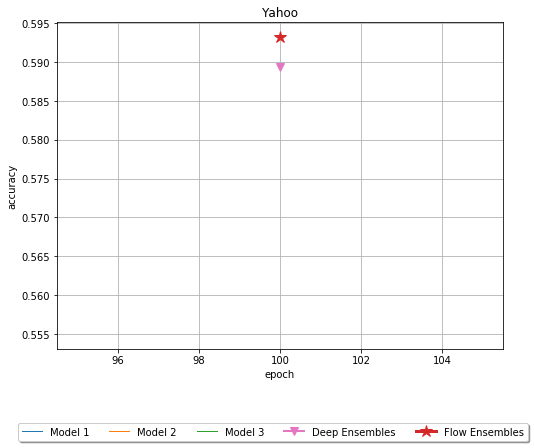

In [11]:
# fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig, ax = plt.subplots(figsize=(8, 6))

Ensembles.plot_results(ensembles.results, ax, 'Yahoo')

plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

0.20042482405900955
0.18033123871088028
0.17721404213905334
0.1712931526839733
0.1764478796720505


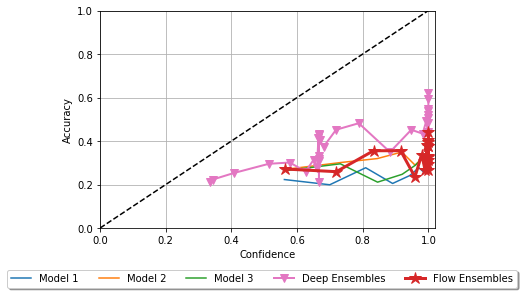

In [50]:
num_bins=60


# plt.figure(figsize=(10, 5))
for i in range(len(res)):
    calibration_dict = calibration_curve(res[i][1], res[i][3], num_bins=num_bins)
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], 
             label="Model {}".format(i+1), color='C{}'.format(i))
    print(calibration_dict["ece"])
calibration_dict_en = calibration_curve(en_probs, res[0][3], num_bins=num_bins)
print(calibration_dict_en["ece"])
plt.plot(calibration_dict_en["confidence"], calibration_dict_en["accuracy"], "-v", lw=2, 
         markersize=8, label="Deep Ensembles", color='C6')

calibration_dict_en2 = calibration_curve(en_probs2, res[0][3], num_bins=num_bins)
print(calibration_dict_en2["ece"])
plt.plot(calibration_dict_en2["confidence"], calibration_dict_en2["accuracy"], "-*", lw=3, 
         markersize=12, label="Flow Ensembles", color='C3')

plt.ylabel("Accuracy")
plt.xlabel("Confidence")
plt.plot([0, 1], [0, 1], "--k")
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.xlim(0,1.02)
plt.ylim(0,1)
plt.grid()
plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

In [17]:
np.sum(np.max(en_probs2,1) < .9)

750

In [101]:
def compare(x):
    n,m= 0,0
    for i in range(7600):
        if res[x][2][i]!=res[y][2][i]:
            n+=1
            if(np.max(res[x][1][i]) < 0.95 or np.max(res[y][1][i]) < 0.95):
                m+=1
                a = np.around(res[x][1][i], decimals=2)
                b = np.around(res[y][1][i], decimals=2)
#                 print(i,a,b)
    print(n,m)
    print(n/10000,m/10000)



In [102]:
compare(0,1)
compare(0,2)
compare(1,2)

1817 709
0.1817 0.0709
1764 679
0.1764 0.0679
1768 707
0.1768 0.0707


In [126]:
def compare2(x):
    n,m= 0,0
    for i in range(7600):
        if res[x][2][i]!=en_result[2][i]:
            n+=1
            if(np.max(res[x][1][i]) < 0.8 or np.max(en_result[1][i]) < 0.8):
                m+=1
                a = np.around(res[x][1][i], decimals=2)
                b = np.around(en_result[1][i], decimals=2)
                print(b)
    print(n,m)
    print(n/10000,m/10000)

In [127]:
compare2(0)
# compare2(1)
# compare2(2)

[0.   0.   0.65 0.33 0.   0.   0.   0.   0.   0.02]
[0.59 0.   0.   0.   0.   0.12 0.09 0.03 0.18 0.  ]
[0.  0.  0.  0.  0.  0.  0.6 0.  0.4 0. ]
[0.   0.33 0.   0.67 0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.69 0.   0.   0.   0.28 0.03]
[0.   0.   0.   0.   0.33 0.33 0.   0.   0.33 0.  ]
[0.   0.   0.   0.   0.33 0.28 0.   0.34 0.   0.05]
[0.   0.33 0.33 0.   0.33 0.   0.   0.   0.   0.  ]
[0.   0.   0.33 0.   0.43 0.24 0.   0.   0.   0.  ]
[0.33 0.   0.   0.   0.   0.   0.   0.   0.   0.67]
[0.   0.   0.32 0.33 0.33 0.   0.   0.   0.02 0.  ]
[0.   0.   0.   0.   0.33 0.   0.   0.67 0.   0.  ]
[0.   0.   0.03 0.   0.31 0.   0.   0.67 0.   0.  ]
[0.   0.   0.   0.   0.33 0.   0.   0.34 0.33 0.  ]
[0.   0.   0.   0.37 0.   0.   0.   0.63 0.   0.  ]
[0.   0.   0.   0.   0.36 0.   0.33 0.31 0.   0.  ]
[0.   0.   0.   0.04 0.29 0.   0.   0.   0.33 0.33]
[0.33 0.67 0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.33 0.   0.33 0.   0.33 0.   0.   0.  ]
[0.   0.   0.   0.   0

[0.   0.33 0.   0.   0.09 0.24 0.   0.33 0.   0.  ]
[0.   0.   0.   0.   0.   0.67 0.   0.   0.33 0.  ]
[0.   0.   0.   0.   0.   0.   0.   0.19 0.22 0.59]
[0.   0.   0.   0.27 0.   0.   0.   0.4  0.   0.33]
[0.66 0.   0.   0.   0.   0.   0.34 0.   0.   0.  ]
[0.   0.   0.07 0.55 0.   0.37 0.   0.   0.   0.  ]
[0.   0.   0.46 0.   0.   0.   0.   0.   0.54 0.  ]
[0.29 0.   0.35 0.   0.2  0.   0.06 0.   0.1  0.  ]
[0.   0.   0.   0.   0.   0.   0.   0.25 0.65 0.1 ]
[0.41 0.   0.   0.   0.   0.   0.   0.59 0.   0.  ]
[0.67 0.33 0.   0.   0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.33 0.   0.   0.67 0.   0.  ]
[0.   0.33 0.   0.   0.   0.   0.   0.67 0.   0.  ]
[0.19 0.   0.11 0.   0.33 0.3  0.   0.06 0.   0.  ]
[0.  0.8 0.2 0.  0.  0.  0.  0.  0.  0. ]
[0.35 0.   0.   0.   0.   0.   0.   0.65 0.   0.  ]
[0.   0.   0.55 0.   0.   0.33 0.   0.12 0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.01 0.   0.44 0.55]
[0.   0.   0.   0.   0.   0.33 0.   0.67 0.   0.  ]
[0.32 0.   0.   0.3  0

[0.   0.   0.32 0.   0.35 0.   0.   0.   0.33 0.  ]
[0.   0.   0.67 0.   0.   0.   0.33 0.   0.   0.  ]
[0.66 0.   0.   0.   0.   0.   0.34 0.   0.   0.  ]
[0.67 0.16 0.   0.   0.   0.   0.   0.   0.17 0.  ]
[0.   0.   0.   0.   0.   0.71 0.   0.   0.29 0.  ]
[0.   0.   0.   0.   0.24 0.76 0.   0.   0.   0.  ]
[0.   0.   0.   0.72 0.   0.   0.   0.   0.28 0.  ]
[0.33 0.   0.33 0.   0.33 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.33 0.   0.01 0.67 0.   0.  ]
[0.67 0.   0.   0.   0.   0.   0.33 0.   0.   0.  ]
[0.   0.   0.33 0.33 0.   0.   0.   0.   0.   0.33]
[0.67 0.   0.   0.   0.   0.33 0.   0.   0.   0.  ]
[0.13 0.   0.34 0.   0.   0.32 0.   0.21 0.   0.  ]
[0.   0.03 0.   0.   0.   0.   0.   0.   0.33 0.63]
[0.   0.   0.67 0.   0.33 0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.33 0.   0.67 0.   0.   0.   0.  ]
[0.   0.   0.   0.   0.   0.   0.   0.   0.26 0.74]
[0.   0.   0.   0.   0.   0.67 0.   0.33 0.   0.  ]
[0.68 0.   0.   0.   0.   0.   0.   0.32 0.   0.  ]
[0.17 0.7  0

In [175]:
en_result[2][0], en_pred2[0], targets[0]

(9, 9, 7)

In [29]:
def compare3():
    n,m= 0,0
    ma = 0.9
    ltrue,rtrue=0,0
    diff=0
    diff2=0
    for i in range(10000):
        if en_result[2][i]!=en_pred2[i]:
            n+=1
            if(np.max(en_result[1][i]) < ma or np.max(en_probs2[i]) < ma):
                m+=1
                a = en_result[1][i]
                b = en_probs2[i]
                
                
                l = np.argmax(a)==targets[i]
                r = np.argmax(b)==targets[i]
                if l:
                    ltrue+=1
                if r:
                    rtrue+=1
                print(l,r)
                if l == False and r == True:
                    diff+=1
                    print(np.max(a), np.max(b))
#                     print(a,b,targets[i])
#                     print(np.argmax(a),np.argmax(a)==targets[i],np.argmax(b),np.argmax(b)==targets[i])
                if l == True and r == False:
                    diff2+=1
    print(n,m)
    print(ltrue,rtrue,diff,diff2)

compare3()


False True
0.642655 0.5566164
True False
False True
0.66664004 0.99354786
True False
False False
True False
True False
False False
True False
True False
False True
0.47931 0.97135174
False False
False True
0.6666667 0.67327225
False True
0.558474 0.5256914
False True
0.65967244 0.5043921
False True
0.52263397 0.9989706
False True
0.61927867 0.9999989
False False
False False
False False
False False
False False
False False
True False
False True
0.66564703 0.99603385
False False
False False
False True
0.66663975 0.86023706
False False
False False
False True
0.3824869 0.54191923
False True
0.55148417 0.99994874
False False
True False
False False
False False
False False
True False
False False
False False
False False
False True
0.6146098 0.9828604
False True
0.66666657 0.88231385
False False
True False
False False
False False
False False
True False
False True
0.666369 0.84308803
False True
0.62598515 0.5928149
False False
False False
True False
False True
0.33333328 0.65426755
False True
0.5

In [168]:
9378 +622 

10000

In [18]:
(998   +131   )/10000

0.1129

In [172]:
(5634+165)/10000

0.5799

In [136]:
accuracy(en_pred2, targets)

0.5801

In [148]:
def get_nll(probs, targets):
    labels = targets.astype(int)
    idx = (np.arange(targets.size), targets)
    ps = probs[idx]
    nll = -np.sum(np.log(ps))
    return nll

In [49]:
np.max(results[0][1], 1).shape[0]

7600

In [88]:
results[0][1], results[0][3]

(array([[0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [1.9253276e-11, 7.3845300e-27, 1.3460834e-15, 1.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 2.1072536e-35, 1.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 2.1059960e-39, 1.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00]],
       dtype=float32), array([1, 3, 2, ..., 3, 3, 3]))

In [129]:
calibration_curve(results[0][1], results[0][3], 20)

{'accuracy': array([0.39050132, 0.48318043]),
 'confidence': array([0.89943546, 0.99993634], dtype=float32),
 'ece': 0.047613845193072366,
 'proportions': array([0.04986842, 0.04302632])}

In [159]:
results[0][1][1]

array([1.9253276e-11, 7.3845300e-27, 1.3460834e-15, 1.0000000e+00],
      dtype=float32)

In [154]:
np.log(np.min(results[0][1]))

/share/apps/anaconda3/5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

0.04683708248954071
inf
0.05254808072981081
inf
0.046566189590253326
inf
0.04521723664120624
inf
0.048803385080475555
inf


/share/apps/anaconda3/5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


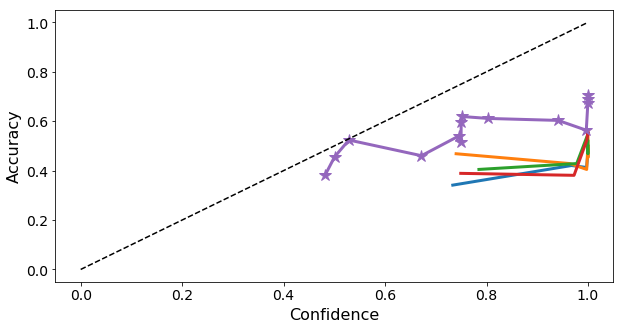

In [149]:
num_bins=60


plt.figure(figsize=(10, 5))
for i in range(4):
    calibration_dict = calibration_curve(results[i][1], results[i][3], num_bins=num_bins)
    plt.plot(calibration_dict["confidence"], calibration_dict["accuracy"], lw=3, 
             label="run {}".format(i))
    print(calibration_dict["ece"])
    print(get_nll(results[i][1], results[i][3]))
calibration_dict_en = calibration_curve(en_probs, results[0][3], num_bins=num_bins)
print(calibration_dict_en["ece"])
print(get_nll(en_probs, results[0][3]))
plt.plot(calibration_dict_en["confidence"], calibration_dict_en["accuracy"], "-*", lw=3, 
         markersize=12, label="Ensemble")

plt.ylabel("Accuracy", fontsize=16)
plt.xlabel("Confidence", fontsize=16)
plt.plot([0, 1], [0, 1], "--k")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

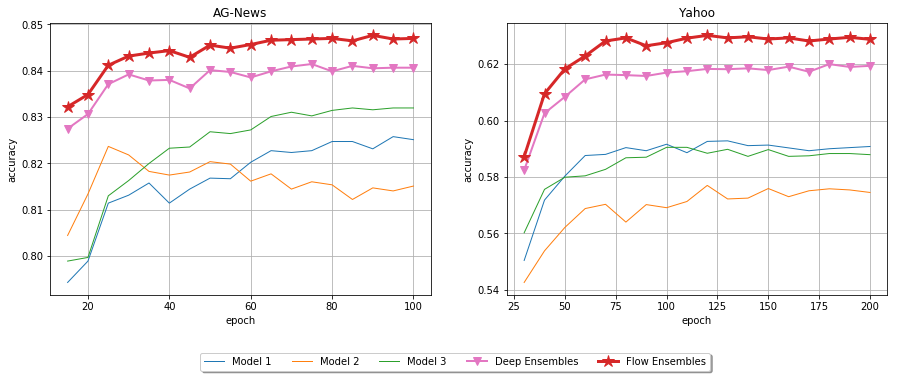

In [8]:
results_ag = Ensembles.load_results('results/AG_News-ensembles-002.json')
results_yahoo = Ensembles.load_results('results/YAHOO-ensembles-538.json')

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
# fig, ax = plt.subplots(figsize=(8, 6))
Ensembles.plot_results(results_ag, ax1, 'AG-News', start=2)
Ensembles.plot_results(results_yahoo, ax2, 'Yahoo', start=2)

plt.legend( loc = 'lower center', bbox_to_anchor = (0,-0.1,1,1),
            bbox_transform = plt.gcf().transFigure,fancybox=True, shadow=True, ncol=5 )
plt.show()

In [2]:
import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla V100-SXM2-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
